# Tutorial básico de Julia/JuMP.

JuMP es un paquete del lenguaje de programación Julia que permite formular problemas de optimización en general,
y de programación matemática en particular. En JuMP se puede modelar de manera simple, programas lineales, enteros
y mixtos, así como ciertos problemas no lineales y de satisfacción de restricciones. JuMP en combinación con Julia
pueden conectarse a solvers libres (GLPK, Cbc, etc.) y comerciales (CPLEX y GUROBI entre otros) para solucionar los
problemas modelados. Este es un tutorial que le permitirá familiarizarse con JuMP. Le recomendamos *fuertemente*
que lo complete antes del laboratorio 1 ya que muchas dudas que surgirán en el laboratorio están resueltas aquí.

Instrucciones para instalar JuMP/Julia/Gurobi en su computador personal están disponibles en UCursos.

## Primer programa lineal.

Suponga usted que quiere resolver el sistema lineal
$$
\begin{array}{rcll}
(\text{Ej1}): & \min_{a,b} & a+12b \\
& s.a. & 13a+12c\leq 5-2b & (r1) \\
&& a+c\geq 1 & (r2)\\
&& 15a+b=14+3b & (r3)\\
&& a\geq 0, b\leq 0, c\in\mathbb{R} 
\end{array}
$$
Para esto, basta ejecutar la siguiente secuencia de comandos: 

In [ ]:
using JuMP, Gurobi
model = Model(Gurobi.Optimizer)
@variable(model,a>=0)
@variable(model,b<=0)
@variable(model,c)
@objective(model, Min, a + 12b)
@constraint(model, r1, 13a+12c <= 5-2b)
@constraint(model, r2, a + c >= 1)
@constraint(model, r3, 15a+b == 14+3b);

<div class="alert alert-info"><b>Nota:</b> El comando <b>using Foo</b> carga el módulo o paquete de nombre <b>Foo</b> y permite usar las funciones y nombres que el paquete exporta. Los mismos nombres se pueden usar con la sintaxis de punto, i.e., escribiendo <b>Foo.foo</b></div>


Para ver el modelo especificado, ejecute el siguiente comando:

In [ ]:
println(model)

Para resolver el sistema lineal, ejecute el siguiente comando:

In [ ]:
optimize!(model);

El mensaje nos indica que JuMP llamó al solver Gurobi para resolver el problema, que la función objetivo del
programa lineal es -84.0, y nos indica, entre otras cosas, el tiempo en que fue encontrada la solución.

<div class="alert alert-info"><b>Nota:</b> El ! al final de optimize es parte del nombre del comando. Julia tiene por convención que aquellas funciones que modifican sus argumentos terminan con !.<div>

El comando <tt>all_variables()</tt> permite listar todas las variables de un modelo dado. Para obtener una descripción de un comando anteponga el símbolo ? al nombre, como en la siguiente celda:

In [ ]:
?all_variables()

A continuación ejecute el comando y verifique que genera la salida descrita en el paso anterior:

In [ ]:
all_variables(model)

Combinando los comandos <tt>all_variables()</tt> y <tt>value()</tt> podemos recuperar los valores de una solución óptima de (Ej1):

In [ ]:
for incog in all_variables(model)
    println(incog," = ",value(incog))
end

Usando la característica de Julia que permite ejecutar un comando, digamos, en cada elemento de un arreglo, solo con agregarle un punto (".") al nombre de la instrucción. Por ejemplo, para obtener el mismo resultado generado por la última celda de comandos así:

In [ ]:
value.(all_variables(model))

En la siguiente celda investigue y ejecute cada uno de los siguientes comandos: <tt>objective_value()</tt>, <tt>num_variables()<tt>, <tt>all_constraints()</tt>, <tt>num_constraints()</tt>, <tt>shadow_price()</tt> (puede que requiera usar <tt>println()</tt> para imprimir el resultado de alguno de los comandos).

In [ ]:
println("valor objetivo = ", objective_value(model))
println("numero de variables = ", num_variables(model))
println(all_constraints(model; include_variable_in_set_constraints = false))
println("numero de restricciones = ", num_constraints(model; count_variable_in_set_constraints = false))      
println("valor variables duales = ", shadow_price.([r1,r2,r3]))

Formule ahora el mismo programa lineal (Ej1) pero donde cambiamos el lado derecho de la restricción $(r2)$ de $1$ a $10$. Puede serle útil explorar el uso del comando <tt>set_normalized_rhs()</tt>.

Para concluir esta sección, modifique el programa lineal (Ej1) eliminando la restricción de no-negatividad de la variable <tt>a</tt> (use el comando <tt>delete_lower_bound()</tt>) y resuelva el programa lineal resultante. 

Observe que el status de término es ambiguo (es infactible o no acotada). Esto típicamente ocurre porque antes de resolver un programa lineal, los solvers los simplifican aplicando ciertas heurísticas. Estas heurísticas son tan buenas que a veces resuelven el problema o determinan que no se puede encontrar una solución óptima. 

A continuación le pasaremos un argumento a Gurobi que le indica no usar su presolver (ahora el estatus de término *no* es ambiguo), y finalmente imprimimos la solución encontrada.

In [ ]:
set_optimizer_attribute(model,"Presolve",false)
optimize!(model)
value.(all_variables(model))

Notar que ahora si hemos podido establecer que el objetivo es no acotado. Pero, la solución que obtenemos *no* es factible, sino más bien un rayo de crecimiento de la función objetivo.

<div class="alert alert-success"><b>Pregunta para la casa:</b>¿Cómo determinar una solución factible?</div>

<div class="alert alert-info"><b>Nota:</b> Hay que tener cuidado, ya que dependiendo del algoritmo que use el solver, es posible que éste reporte
una dirección de no acotamiento sin siquiera calcular una solución primal factible. Para forzar a Gurobi que
encuentre una solución factible usted puede pedirle que encuentre una solución factible, eliminando primero
la función objetivo y luego resolviendo el problema de factibilidad resultante. Desafortunadamente, al parecer
JuMP v0.19 no provee la funcionalidad para remover funciones objetivos por lo que para resolver el problema
de factibilidad deberá volver a generar el modelo sin función objetivo.<div>

<div class="alert alert-info"><b>Nota:</b> Eventualmente vamos a resolver secuencias de problemas cuyas soluciones determinarán las acciones que
vayamos tomando. De lo que hemos visto, es claro que no podemos confiar en que los valores de las variables
que retorna el solver son puntos factibles (pueden ser direcciones de no acotamiento). Por ello, siempre se
deberá verificar el estatus de término de la optimización.</div>

El status de término que resulta de invocar <tt>optimize!(model)</tt> se obtiene ejecutando <tt>termination_status(model)</tt>. Para obtener una lista de posibles estados de término, ejecute el siguiente comando:


In [ ]:
?MOI.TerminationStatusCode

## Un programa lineal entero

En esta sección vamos a estudiar el problema que consiste en determinar el máximo número de celdas de un tablero de un juego de Sudoku que se pueden completar dado un llenado parcial inicial del tablero.  Para ello, se sugiere usar variables binarias $x_{r,c,k}$ que toman el valor $1$ si y solo si el dígito $k$ se coloca o no en la fila $r$ y la columna $c$ del tablero de Sudoku, y considerar la siguiente formulación:
$$
\begin{array}{rll}
\text{(Sdk)}: & \max\sum_{r,c,k\in [9]} x_{r,c,k} \\
s.a. &  \sum_{k\in [9]} x_{r,c,k} \leq 1,\, \forall r,c\in [9], \\
& \sum_{c\in [9]} x_{r,c,k} \leq 1,\, \forall r,k\in [9], \\
& \sum_{r\in [9]} x_{r,c,k} \leq 1,\, \forall c,k\in [9], \\
& \sum_{a,b\in\{0,1,2\}} x_{i+a,j+b,k} \leq 1,\, \forall i,j\in [9]\\
& \quad x_{r,c,k}\in\{0,1\},\,\forall r,c,k\in\{1,4,7\}.
\end{array}
$$

Las instancias a considerar estarán especificadas por una matriz de $9\times 9$. Por ejemplo, la primera de las instancias de la siguiente imagen

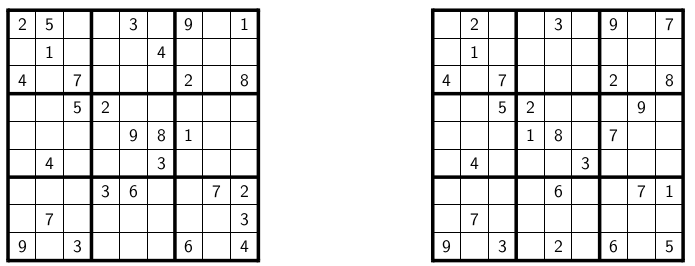

esta dada por la matriz

In [ ]:
A = [2 5 0 0 3 0 9 0 1; 
     0 1 0 0 0 4 0 0 0; 
     4 0 7 0 0 0 2 0 8; 
     0 0 5 2 0 0 0 0 0; 
     0 0 0 0 9 8 1 0 0; 
     0 4 0 0 0 3 0 0 0; 
     0 0 0 3 6 0 0 7 2;
     0 7 0 0 0 0 0 0 3;
     9 0 3 0 0 0 6 0 4];

<div class="alert alert-info"><b>Nota:</b> Observe que al agregar ";" al final de un comando de Julia se suprime la salida que este pudiera generar. Esto es útil cuando se quiere evitar generar resultados de comandos que no son relevantes para la tarea que se esté realizando.</div>

Complete la siguiente formulación parcial de (Sdk) en Julia/JuMP:


In [ ]:
using JuMP, Gurobi                               # Carga modulos
sudoku = Model(Gurobi.Optimizer)                 # Crea modelo

# Define estructuras utiles
rows = 1:9;
cols = 1:9;
nums = 1:9;
esqn = [1, 4, 7];

# Creae las variables


# Cree las restricciones


# Defina el objetivo


Resuelva las dos instancias de Sudoku de la imagen de más arriba y compruebe que ambas instancias se pueden rellenar obteniendo de forma de obtener un tablero completo válido.

In [ ]:
optimize!(sudoku)